# Tuolumne @ 120 2001 - 2021: Combing New and Old Datasets
Joe Ammatelli | 8-22-22

This notebook facilitates joining the old dataset with the new dataset (accounting for potentially disimilar labels). For backwards compatability, in the event the old and new datsets overlap in time, we join the new dataset with the end of the old dataset, trimming overlapping data from the new dataset. 


Once all steps have been completed, a single .csv file with the following quantities will be generated (and will span the entire period for which data is available across both the new and old file).
* date and time (UTC)
* vented pressure, cm
* raw pressure, cm
* barocorrected pressure, cm
* adjusted stage, cm
* estimated discharge, cms
* water temperature, degrees C
* discharge flag

Author of Template and Underlying Code: Joe Ammatelli | (jamma@uw.edu) | August 2022

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

sys.path.insert(0, os.path.abspath(os.path.join('..', '..', 'src')))

import config
import level_baro_utils

sys.path.remove(os.path.abspath(os.path.join('..', '..', 'src')))

## Configure Plotting Preferences
**Analyst TODO:**
* Choose plotting backend:
    - Interactive (recommended): uncomment `%matplotlib notebook` and `FIGSIZE=NONE`; comment out `FIGSIZE = config.FIGSIZE`
    - Inline: comment out `%matplotlib notebook` `FIGSIZE=NONE`; uncomment `FIGSIZE = config.FIGSIZE`

In [2]:
%matplotlib notebook
FIGSIZE=None

#FIGSIZE = config.FIGSIZE

sns.set_theme()

## Specify site code and define start/end years of new series
**Analyst TODO**:
* assign an integer representing the site to the variable `sitecode`. Mappings are as follows (follows from upstream to downstream):
    * 0 : Lyell Below Maclure
    * 1 : Lyell Above Twin Bridges
    * 2 : Dana Fork at Bug Camp
    * 3 : Tuolumne River at Highway 120
    * 4 : Budd Creek
    * 5 : Delaney Above PCT
* assign an integer (format 'YYYY') representing the first year of data collection to `start_year`
* assign an integer (format 'YYYY') representing the last year of data collection to `end_year`

These input parameters are used to automatically retrieve the postprocessed data.

In [3]:
sitecode = 3

start_year = 2019
end_year = 2021

## Read in both datasets
**Analyst TODO:** Ensure each column is appropriate datatype, correct as necessary by mapping column number to datatype in dictionary called `dtypes` and calling `choose_column_dtype` function (can leave `dtypes` as empty dictionary otherwise); ensure there is a column in the old table for each column of the new table, add new columns as necessary; inspect the resultant tables

**Old Dataset**

In [4]:
old_fn = 'Tuolumne120_timeseries_stage_Q_T_2002_2018.csv'
old_path = os.path.join('..', '..', 'compiled_data', 'published', old_fn)
old_df = pd.read_csv(old_path, index_col=0, parse_dates=[0], infer_datetime_format=True, na_values=[' NaN'])

/Users/jamma/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,4,5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
old_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259551 entries, 2001-10-30 19:59:00 to 2018-06-25 22:30:00
Data columns (total 10 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0    raw_pressure(cm)                            259551 non-null  float64
 1    barocorrected_pressure(cm)                  259551 non-null  object 
 2    offset(cm)                                  259551 non-null  float64
 3    stage(cm)                                   259551 non-null  object 
 4    estimated_discharge(cms)                    259551 non-null  object 
 5   lower_confidence_discharge_cms_bestestimate  259551 non-null  object 
 6   upper_confidence_discharge_cms_bestestimate  259551 non-null  object 
 7    instrument_ID                               259551 non-null  int64  
 8    water_temperature(deg_C)                    259551 non-null  object 
 9    discharge flag          

Explicity choose datatype for incorrect columns of interest (read_csv sometimes chooses wrong datatype for some columns and won't allow me to convert from certain types to others) -- This step should not be necessary for future processing.

In [6]:
dtypes = {1:np.float64,
          3:np.float64,
          4:np.float64,
          5:np.float64,
          6:np.float64,
          8:np.float64}

In [7]:
old_df = level_baro_utils.choose_column_dtype(old_df, dtypes)

In [8]:
old_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259551 entries, 2001-10-30 19:59:00 to 2018-06-25 22:30:00
Data columns (total 10 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0    raw_pressure(cm)                            259551 non-null  float64
 1    barocorrected_pressure(cm)                  259549 non-null  float64
 2    offset(cm)                                  259551 non-null  float64
 3    stage(cm)                                   259549 non-null  float64
 4    estimated_discharge(cms)                    259549 non-null  float64
 5   lower_confidence_discharge_cms_bestestimate  242046 non-null  float64
 6   upper_confidence_discharge_cms_bestestimate  242046 non-null  float64
 7    instrument_ID                               259551 non-null  int64  
 8    water_temperature(deg_C)                    259550 non-null  float64
 9    discharge flag          

In [9]:
old_df.head()

,raw_pressure(cm),barocorrected_pressure(cm),offset(cm),stage(cm),estimated_discharge(cms),lower_confidence_discharge_cms_bestestimate,upper_confidence_discharge_cms_bestestimate,instrument_ID,water_temperature(deg_C),discharge flag
date_time(UTC:LDT+7),,,,,,,,,,
2001-10-30 19:59:00,179.4,119.4,-38.0,81.4,0.35,-0.15,0.72,1,4.72,2
2001-10-30 21:00:00,179.5,120.2,-38.0,82.2,0.39,-0.10,0.77,1,4.72,2
2001-10-30 21:59:00,179.7,120.5,-38.0,82.5,0.41,-0.09,0.79,1,4.67,2
2001-10-30 23:00:00,180.5,121.4,-38.0,83.4,0.47,-0.04,0.85,1,4.38,2
2001-10-30 23:59:00,181.3,121.9,-38.0,83.9,0.50,-0.00,0.88,1,4.01,2


**New Dataset**

In [10]:
new_fn = config.FINAL_OUTPUT_FN.format(site=config.SITE_SHORTNAME[sitecode],
                                       start=start_year,
                                       end=end_year)

new_path = os.path.join('..', '..', 'stitch_discharge', 'data', 'processed', new_fn)

new_df = pd.read_csv(new_path, index_col=0, parse_dates=[0], infer_datetime_format=True)

Inspect resultant tables

In [11]:
new_df.head()

,raw_pressure(cm),barocorrected_pressure(cm),adjusted_stage(cm),estimated_discharge(cms),water_temperature(deg_C),discharge_flag
date_time(UTC:PDT+7),,,,,,
2018-06-01 00:00:00,188.00064,188.00064,161.131247,14.327213,8.835,0
2018-06-01 00:30:00,188.70168,188.70168,161.832287,14.521164,8.940,0
2018-06-01 01:00:00,189.85992,189.85992,162.990527,14.844032,8.875,0
2018-06-01 01:30:00,190.65240,190.65240,163.783007,15.066680,8.665,0
2018-06-01 02:00:00,191.90208,191.90208,165.032687,15.420637,8.405,0


## If the old dataset has different column names than the new dataset, map the old names to the new ones
This step exists to compensate for different header labels used in prior datasets. Moving forward (as of the release of the first version of this processing suite, attempts are made to have a consisistent labelling scheme so that this step is not necessary in the future).

### Specify the old label names
**Analyst TODO**:
If the old dataset uses different header names, defines of the header names in the appropriate variable below (leave as empty string otherwise).

e.g.
* if the old dataset uses the label `stage (cm)` to describe the offset stage value, set the variable `adjusted_stage_label` equal to `stage (cm)`

In [12]:
raw_pressure_label = ' raw_pressure(cm)'
barocorrected_pressure_label = ' barocorrected_pressure(cm)'
adjusted_stage_label = ' stage(cm)'
estimated_discharge_label = ' estimated_discharge(cms)'
water_temperature_label = ' water_temperature(deg_C)'
discharge_flag_label = ' discharge flag'

old_labels = [raw_pressure_label, 
              barocorrected_pressure_label, 
              adjusted_stage_label, 
              estimated_discharge_label,
              water_temperature_label,
              discharge_flag_label]

### Update the header of the old dataset dataframe to match the header of the new dataset dataframe
**Analyst TODO:** Run cells

In [13]:
old_df = level_baro_utils.map_old_labels_2_new(old_df, old_labels)
old_df.head()

,raw_pressure(cm),barocorrected_pressure(cm),adjusted_stage(cm),estimated_discharge(cms),water_temperature(deg_C),discharge_flag
date_time(UTC:LDT+7),,,,,,
2001-10-30 19:59:00,179.4,119.4,81.4,0.35,4.72,2
2001-10-30 21:00:00,179.5,120.2,82.2,0.39,4.72,2
2001-10-30 21:59:00,179.7,120.5,82.5,0.41,4.67,2
2001-10-30 23:00:00,180.5,121.4,83.4,0.47,4.38,2
2001-10-30 23:59:00,181.3,121.9,83.9,0.50,4.01,2


## Join the old data frame with the new dataframe (only the columns they have in common: namely the labels listed in the previous step)
**Analyst TODO:** Run cells

In [14]:
resultant_df, boundary = level_baro_utils.join_dataframes(old_df, new_df)

# may need to override datatype of some columns
resultant_df['estimated_discharge(cms)'] = resultant_df['estimated_discharge(cms)'].astype(np.float64)

resultant_df.head()

Joining old and new series
End of old series: 2018-06-25 22:30:00
Start of new series: 2018-06-25 23:00:00


,raw_pressure(cm),barocorrected_pressure(cm),adjusted_stage(cm),estimated_discharge(cms),water_temperature(deg_C),discharge_flag
2001-10-30 19:59:00,179.4,119.4,81.4,0.35,4.72,2
2001-10-30 21:00:00,179.5,120.2,82.2,0.39,4.72,2
2001-10-30 21:59:00,179.7,120.5,82.5,0.41,4.67,2
2001-10-30 23:00:00,180.5,121.4,83.4,0.47,4.38,2
2001-10-30 23:59:00,181.3,121.9,83.9,0.50,4.01,2


## Inspect result around boundary of old/new dataset
**Analyst TODO** Inspect the results. Verify boundary of new and old series does not have duplicated values

<IPython.core.display.Javascript object>


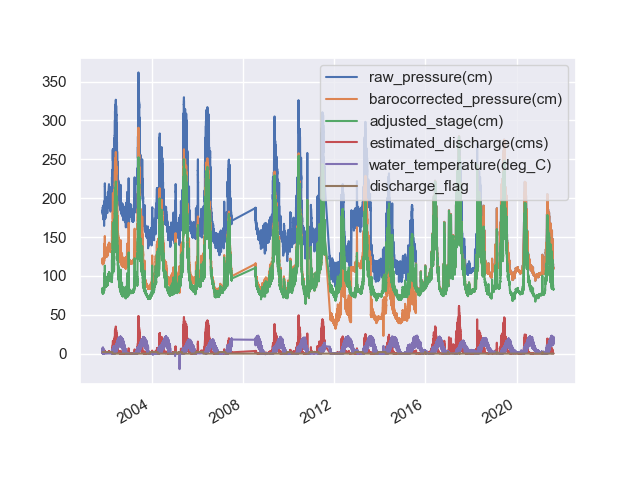

<AxesSubplot:>

In [15]:
resultant_df.plot()

<IPython.core.display.Javascript object>


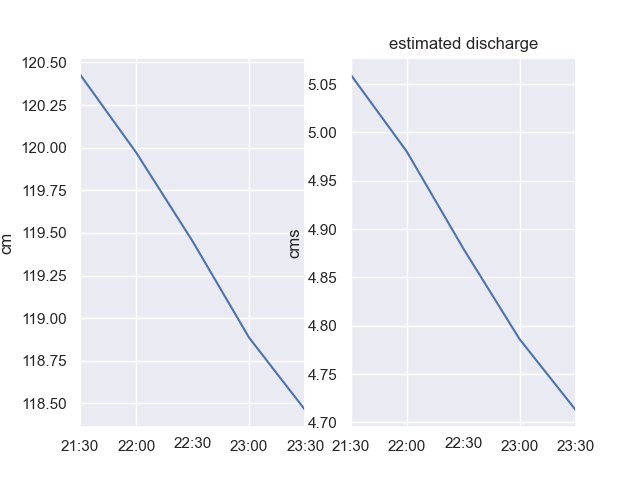

,raw_pressure(cm),barocorrected_pressure(cm),adjusted_stage(cm),estimated_discharge(cms),water_temperature(deg_C),discharge_flag
2018-06-25 21:30:00,147.59000,120.43000,120.430000,5.060000,15.790,0
2018-06-25 22:00:00,147.13000,119.97000,119.970000,4.980000,16.250,0
2018-06-25 22:30:00,146.61000,119.45000,119.450000,4.880000,16.660,0
2018-06-25 23:00:00,145.75536,145.75536,118.885967,4.786102,16.890,0
2018-06-25 23:30:00,145.32864,145.32864,118.459247,4.712500,17.105,0


In [16]:
level_baro_utils.plot_boundary(resultant_df, boundary)

## Save Series

In [17]:
first_year = old_df.index[0].year
last_year = new_df.index[-1].year

level_baro_utils.save_final_data(resultant_df, sitecode, first_year, last_year)

Wrote data to ../data/processed/Tuolumne@120_timeseries_stage_Q_T_2001_2021.csv
